# 데이터 분석

- 학습 step마다 4가지 라벨 [`company`, `address`, `date`, `total`]의 성능 변화 확인
    - dev 데이터에서는 좋은 성능을 보이지만, test 데이터에서는 좋지 않은 성능을 보이는 이유를 분석

## 학습 step마다 4가지 라벨 [`company`, `address`, `date`, `total`]의 성능 변화 확인

### dev 데이터에서는 좋은 성능을 보이지만, test 데이터에서는 좋지 않은 성능을 보이는 이유를 분석

#### trian.log 파일에서 평가지표만 라벨별로 추출

In [106]:
import re
import pandas as pd

def extract_table_and_loss(input_file):
    table_lines = []
    losses = []
    dfs = []
    capture_table = False
    skip_empty_line = False
    label_tables_dict = {'address':[], 'company':[], 'date':[], 'total':[], 'micro avg':[], 'macro avg':[], 'weighted avg':[]}

    with open(input_file, 'r') as infile:
        for line in infile:
            # Check for the start of the table
            if re.match(r'\s+precision\s+recall\s+f1-score\s+support', line):
                capture_table = True
                skip_empty_line = True
                continue

            if capture_table:
                # Skip the empty line after the header
                if skip_empty_line:
                    if line.strip() == "":
                        continue
                    skip_empty_line = False
                
                # Capture table lines
                if line.strip() == "":
                    capture_table = False
                else:
                    table_lines.append(line.strip())
                    if re.split(r'\s{2,}', line.strip())[0]=='TOTAL': # skip the last line of the table for micro and macro avg
                        skip_empty_line = True 
            
            # Check for the loss value
            loss_match = re.match(r'.*loss\s+=\s+([0-9.]+)', line)
            if loss_match:
                losses.append(float(loss_match.group(1))) # Extract the loss value in '([0-9.]+)'
    
    # Convert the extracted table to a DataFrame
    for row in table_lines[1:]:  # Skip the header row
        row_data = re.split(r'\s{2,}', row.strip())
        label_tables_dict[row_data[0].lower()].append(row_data[1:]) # [label, precision, recall, f1-score, support] -> [precision, recall, f1-score, support]
    
    columns = ['precision', 'recall', 'f1-score', 'support']

    for label, table_data in label_tables_dict.items():
        # make index starting from 50 and incrementing by 50, create it n times
        index = [50 * i for i in range(1, len(table_data)+1)]

        df = pd.DataFrame(table_data, columns=columns, index=index)
        # Convert numerical columns to appropriate types
        df[['precision', 'recall', 'f1-score']] = df[['precision', 'recall', 'f1-score']].astype(float)
        df['support'] = df['support'].astype(int)

        label_tables_dict[label] = df 

    return label_tables_dict, losses[:-1] # Skip the last loss value (last loss value is the training loss)

In [134]:
# logs dir : ../logs/bert-base-train.log
dfs, losses = extract_table_and_loss('../logs/layoutlm-base.log')

In [135]:
dfs['macro avg']

,precision,recall,f1-score,support
50,0.86,0.82,0.82,2232
100,0.89,0.89,0.89,2232
150,0.91,0.89,0.90,2232
200,0.89,0.92,0.91,2232
250,0.90,0.92,0.91,2232
300,0.91,0.92,0.92,2232
350,0.91,0.93,0.92,2232
400,0.91,0.93,0.92,2232
450,0.90,0.93,0.92,2232
500,0.90,0.93,0.92,2232


#### step 단위로 라벨별 val_f1-score, val_loss를 시각화 

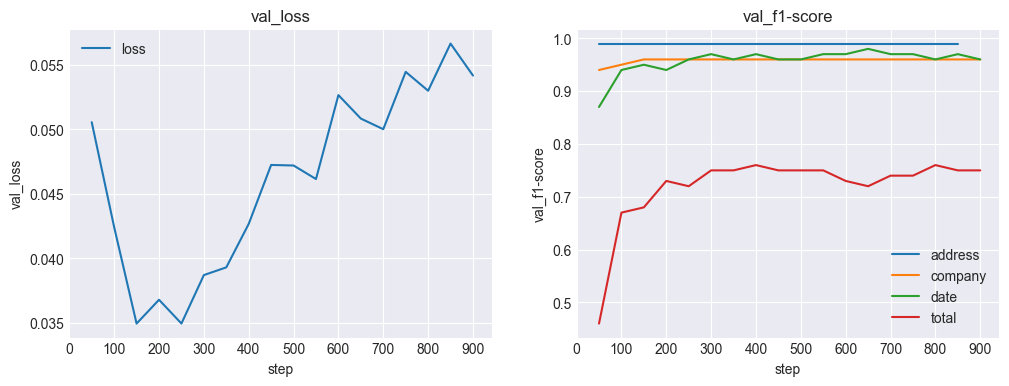

In [136]:
# step 단위로 라벨별 val_f1-score, val_loss를 시각화 
import matplotlib.pyplot as plt
import seaborn as sns

axes, fig = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x=range(50,950,50),y=losses, label='loss', ax=fig[0])
fig[0].set_xticks(range(0,1000,100))
fig[0].set_xlabel('step')
fig[0].set_ylabel('val_loss')
fig[0].set_title('val_loss')
fig[0].legend()

for label, df in dfs.items() :
    if label in ['address', 'company', 'date', 'total']:
        sns.lineplot(data=df['f1-score'], label=label, ax=fig[1])
fig[1].set_xticks(range(0,1000,100))
fig[1].set_xlabel('step')
fig[1].set_ylabel('val_f1-score')
fig[1].set_title('val_f1-score')
fig[1].legend()

plt.show()


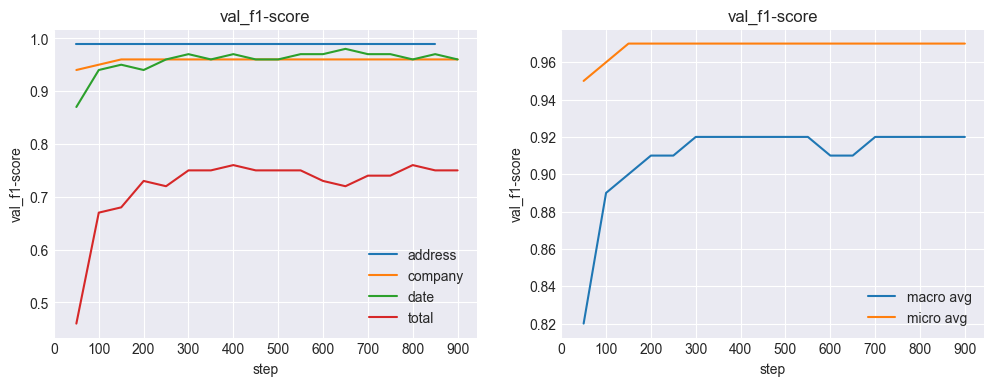

In [137]:
# step 단위로 라벨별 val_f1-score, (micro_avg, macro_avg)를 시각화
axes, fig = plt.subplots(1, 2, figsize=(12, 4))

for label, df in dfs.items() :
    if label in ['address', 'company', 'date', 'total']:
        sns.lineplot(data=df['f1-score'], label=label, ax=fig[0])

fig[0].set_xticks(range(0, 1000, 100))
fig[0].set_xlabel('step')
fig[0].set_ylabel('val_f1-score')
fig[0].set_title('val_f1-score')
fig[0].legend()

sns.lineplot(data=dfs['macro avg']['f1-score'], label='macro avg', ax=fig[1])
sns.lineplot(data=dfs['micro avg']['f1-score'], label='micro avg', ax=fig[1])
fig[1].set_xticks(range(0, 1000, 100))
fig[1].set_xlabel('step')
fig[1].set_ylabel('val_f1-score')
fig[1].set_title('val_f1-score')
fig[1].legend()

plt.show()